In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tueplots import bundles, figsizes
from scipy import stats

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Contamination model

In [2]:
import numpy as np
from scipy.optimize import minimize

class DSMEStimator:
    
    def __init__(self,data, m, grad_m, grad_t, hess_t, grad_b, d=1, p=1):
        self.data = data
        self.p = p
        self.d = d
        self.n = self.data.shape[0]
        

        self.m = m
        self.grad_m = grad_m
        self.grad_t = grad_t
        self.hess_t = hess_t
        self.grad_b = grad_b

        self.A = np.sum([self.Ax(x) for x in self.data],axis=0)/self.n
        self.v = 2*np.sum([self.vx(x) for x in self.data],axis=0)/self.n

    def Ax(self, x):
        return self.grad_t(x).T@self.m(x)@self.m(x).T@self.grad_t(x)
    
    def vx(self, x):
        v1 = (self.grad_t(x).T@self.m(x)@self.m(x)@self.grad_b(x))
        div_mm = np.asarray([[np.sum([[self.grad_m(x)[i,j,i]*self.m(x)[p,j] + self.grad_m(x)[p,j,i]*self.m(x)[i,j]  for i in range(self.d)]for j in range(self.d)])] for p in range(self.d)])
        v2 = self.grad_t(x).T@div_mm
        v3 = np.asarray([[np.trace(self.m(x)@self.m(x).T@self.hess_t(x)[:,:,p])] for p in range(self.p)])
        return v1+v2+v3

    def thetab(self):
        A = self.A
        v = self.v
        return np.linalg.solve(2*A,v)
        

In [3]:
np.random.seed(100)
n= 1000
sigma = 1
Z1 = stats.norm.rvs(size=n)
Z2 = stats.norm.rvs(loc =10, scale = 1,size=n)
rnd = np.random.random(n)

epsilon = 0.05
contaminate = (rnd < epsilon)
X = (contaminate==0) * Z1 + (contaminate==1) * (Z2)

mu, std = stats.norm.fit(X)

In [4]:
def m(x):
    return np.asarray([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.asarray([[-x/((1+x**2)**(3/2))]])

def grad_t(x):
    return np.asarray([[1,-x]],dtype='float')

def grad_b(x):
    return np.asarray([[0]])

def hess_t(x):
    return np.asarray([[[0,-1]]])

beta = 0.1

estimator = DSMEStimator(X.reshape(n,1), m, grad_m, grad_t, hess_t, grad_b)

In [5]:
eta = estimator.thetab()[:,0]
mu_dsm = eta[0]/eta[1]
std_dsm = np.sqrt(1/eta[1])

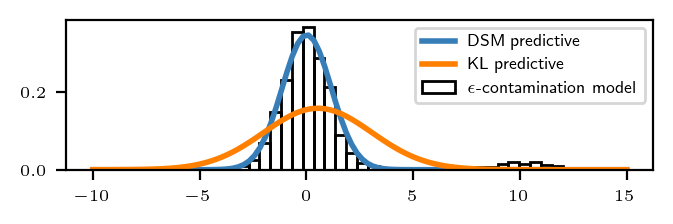

In [6]:
x = np.linspace(-10,15, 100)
FILE_NAME = 'results/aux-figures/contamination.pdf'
with plt.rc_context(bundles.icml2022(ncols=2)):
    plt.subplots(dpi = 200)
    plt.plot(x,stats.norm.pdf(x,loc = mu_dsm, scale = std_dsm),CB_color_cycle[0], lw=2, label='DSM predictive')
    plt.plot(x, stats.norm.pdf(x,loc = mu, scale = std),CB_color_cycle[1], lw=2, label='KL predictive')
    plt.hist(X, density=True, bins=30, label = r' $\epsilon$-contamination model', edgecolor='black', facecolor='none')
    plt.legend()
    plt.savefig(FILE_NAME, format="pdf", bbox_inches= "tight")

In [7]:
np.random.seed(100)
n= 1000
sigma = 1
Z1 = stats.norm.rvs(size=n)
Z2 = 10*np.ones(n)
rnd = np.random.random(n)

epsilon = 0.05
contaminate = (rnd < epsilon)
X = (contaminate==0) * Z1 + (contaminate==1) * (Z2)

mu, std = stats.norm.fit(X)

In [8]:
estimator = DSMEStimator(X.reshape(n,1), m, grad_m, grad_t, hess_t, grad_b)

In [9]:
eta = estimator.thetab()[:,0]
mu_dsm = eta[0]/eta[1]
std_dsm = np.sqrt(1/eta[1])

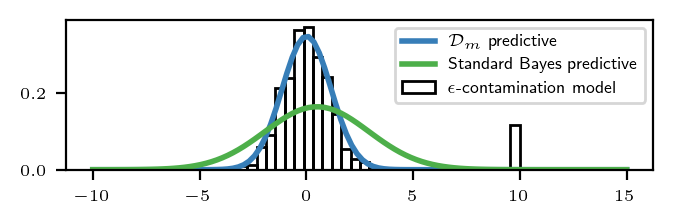

In [10]:
x = np.linspace(-10,15, 100)
FILE_NAME = 'results/aux-figures/contamination2.pdf'
with plt.rc_context(bundles.icml2022(ncols=2)):
    plt.subplots(dpi = 200)
    plt.plot(x,stats.norm.pdf(x,loc = mu_dsm, scale = std_dsm),CB_color_cycle[0], lw=2, label=r'$\mathcal{D}_{m}$ predictive')
    plt.plot(x, stats.norm.pdf(x,loc = mu, scale = std),CB_color_cycle[2], lw=2, label='Standard Bayes predictive')
    plt.hist(X, density=True, bins=30, label = r' $\epsilon$-contamination model', edgecolor='black', facecolor='none')
    plt.legend()
    plt.savefig(FILE_NAME, format="pdf", bbox_inches= "tight")